# 1. Дизайн эксперимента

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

In [2]:
# Считаем размер эффекта
effect_size = sms.proportion_effectsize(0.13, 0.15)
# Cчитаем необходимый размер выборки
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)
# Округляем до ближайшего целого
required_n = ceil(required_n)
print("Для каждой группы нам необходимо не меньше ",required_n, " наблюдений")

Для каждой группы нам необходимо не меньше  4720  наблюдений


# 2. Сбор данных и их подготовка

In [3]:
df = pd.read_csv(r'G:\__ПРЕЗЕНТАЦИИ\ab_test_inference\ab_test_ensembles.csv')
df.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
6,aa9d93c5-a18f-444a-a522-7e7145835362,2022-05-19 03:26:46.940749,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,registered_user
7,de214e30-9b8d-44cf-87b1-16917f3e1c89,2022-05-17 01:48:29.539573,control,standard,0,United Kingdom,18-25,registered_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [5]:
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [6]:
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [7]:
users_to_drop = sessions[sessions > 1].index
df = df[~df['user_id'].isin(users_to_drop)]
print(f"Количество пользователей без дубликтов {df.shape[0]}")

Количество пользователей без дубликтов 294478


# 3. Визуализация Результатов Эксперимента

In [8]:
conversion_rates = df.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.120399,0.325428,0.000848
treatment,0.118920,0.323694,0.000843


Выборочный средний коэффициент конверсии для контрольной группы ~12.04%, для эксперементальной ~11.8%.

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


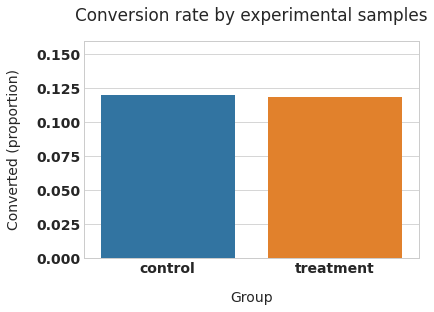

In [9]:
plt.figure();
sns.barplot(x=df['group'], y=df['converted'], ci=False);
plt.ylim(0, 0.16);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

# 4. Тестирование гипотезы

In [10]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.24
p-value: 0.216
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


# Проверка для новых пользователей

In [11]:
df_new_users = df.query('user_type == "new_user"')

In [12]:
conversion_rates_nu = df_new_users.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates_nu.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.120746,0.325832,0.001200
treatment,0.117557,0.322082,0.001188


Выборочный средний коэффициент конверсии среди новых пользователей для контрольной группы ~12.07%, для эксперементальной ~11.8%.

In [13]:
сontrol_results_nu = df_new_users[df_new_users['group'] == 'control']['converted']
treatment_results_nu = df_new_users[df_new_users['group'] == 'treatment']['converted']

n_con_nu = сontrol_results_nu.count()
n_treat_nu = treatment_results_nu.count()
successes_nu = [сontrol_results_nu.sum(), treatment_results_nu.sum()]
nobs_nu = [n_con_nu, n_treat_nu]

z_stat_nu, pval_nu = proportions_ztest(successes_nu, nobs=nobs_nu)
(lower_con_nu, lower_treat_nu), (upper_con_nu, upper_treat_nu) = proportion_confint(successes_nu, nobs=nobs_nu, alpha=0.05)

print(f'Z-statistic: {z_stat_nu:.2f}')
print(f'p-value: {pval_nu:.3f}')
print(f'CI 95% for control group: [{lower_con_nu:.3f}, {upper_con_nu:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat_nu:.3f}, {upper_treat_nu:.3f}]')

Z-statistic: 1.89
p-value: 0.059
CI 95% for control group: [0.118, 0.123]
CI 95% for treatment group: [0.115, 0.120]


# Проверка для старых пользователей

In [14]:
df_registered_users = df.query('user_type == "registered_user"')

In [15]:
conversion_rates_ru = df_registered_users.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates_ru.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.120051,0.325021,0.001199
treatment,0.120277,0.325285,0.001197


Выборочный средний коэффициент конверсии среди старых пользователей для контрольной группы ~12.01%, для эксперементальной ~12.3%.

In [16]:
сontrol_results_ru = df_registered_users[df_registered_users['group'] == 'control']['converted']
treatment_results_ru = df_registered_users[df_registered_users['group'] == 'treatment']['converted']

n_con_ru = сontrol_results_ru.count()
n_treat_ru = treatment_results_ru.count()
successes_ru = [сontrol_results_ru.sum(), treatment_results_ru.sum()]
nobs_ru = [n_con_ru, n_treat_ru]

z_stat_ru, pval_ru = proportions_ztest(successes_ru, nobs=nobs_ru)
(lower_con_ru, lower_treat_ru), (upper_con_ru, upper_treat_ru) = proportion_confint(successes_ru, nobs=nobs_ru, alpha=0.05)

print(f'Z-statistic: {z_stat_ru:.2f}')
print(f'p-value: {pval_ru:.3f}')
print(f'CI 95% for control group: [{lower_con_ru:.3f}, {upper_con_ru:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat_ru:.3f}, {upper_treat_ru:.3f}]')

Z-statistic: -0.13
p-value: 0.894
CI 95% for control group: [0.118, 0.122]
CI 95% for treatment group: [0.118, 0.123]


# 5. Интерпритация результатов

Так как мы видим снижение коэффициента конверсии (с 12.04% до 11.8%) при использовании новой версии сайта, то дизайн сайта не нужно менять на эту версию.
Изменение уровня конверсии не связано с изменением дизайна сайта, так как полученные p-значения (0.216 для всей выборки, 0.059 для новых пользователей, 0.894 для старых пользователей) больше уровня значимости 0,05.
Соответственно мы принимаем нулевую гипотезу.